# "Generic Machine Learning" 
> "Code for generic ML" 

- toc:false
- branch: master
- badges: true
- comments: true
- author: Mun Fai Chan
- categories: [fastpages, jupyter]

This notebook provides code to Generic Machine Learning Inference on Heterogenous Treatment Effects in Randomized Experiments by Victor Chernozhukov, Mert Demirer, Esther Duflo, and Iván Fernández-Val. 

https://arxiv.org/abs/1712.04802

### References 
https://github.com/arnaudfrn/MLheterogeneity/blob/dev/src/vb_heterogeneity_FE.R

Author of notebook : Mun Fai Chan

## Data
In this notebook, I will analyse data by Dana Burde and Leigh L. Linden in Bringing Education to Afghan Girls: A Randomized Controlled Trial of Village-Based Schools. 

The paper can be found here : https://www.jstor.org/stable/43189440?seq=1#metadata_info_tab_contents


<div class="alert alert-block alert-warning">
    
### Developments specific to this data
1. Use small inference t statistic - is this even a valid tool or is this RCT just not very well done? 
2. ~Cluster standard errors (e.g. wild cluster bootstrap) and robust standard errors~ Done
3. ~Read about bootstrap and how this may be incorporated into this code~ Technically, I am doing some form of bootstrap 

 </div>

<div class="alert alert-block alert-info">

### Future Developments for Code 

#### High Priority 
1. ~Add in fixed effects~ Done (Check for errors)  
2. ~Use clustered standard errors ~
3. ~Calculate propensity score for a bigger set of controls. Use a different package for calculating propensity score / use my own code.~ Not needed if I believe that randomisation is done correctly. 
4. Check if I need to use clustered standard errors for the t tests. 
5. Consider if I should add clusters / fixed effects in the CLAN analysis. 
6. Add in diagrams for CLAN. 

#### Medium Priority 
1. Fix problem of breaks being too close to one another (ValueError: bins must increase monotonically.)

2. Hyperparameter tuning on ML estimators and figure out the need to do it - e.g. increasing accuracy of nuisance parameters

3. Convince myself that I don't need clustered standard errors for CLAN - note that CLAN is just a regression of group membership on a control

#### Low Priority 
1. Convert pandas dataframes to LaTex tables. 

#### Long term developments for code 
1. Publish as Python package 
2. Create a website for better documentation

### Other developments for research 
1. Analysis of results for Afghan education dataset (provided fixed effects and standard errors are sorted out) 
2. Randomization checks 
3. Monte Carlo simulation to test veracity and robustness of code
</div>

In [1]:
import import_ipynb
from Generic_ML_script_3 import *
import matplotlib.pyplot as plt

importing Jupyter notebook from Generic_ML_script_3.ipynb


###  Initialisation 

In [2]:
iterations = 100
k = 5 # number of groups for heterogeneity analysis
alpha = 0.05 # significance level 

## Aghan Dataset

In [3]:
df = pd.read_stata("~/OneDrive - London School of Economics/LSE/Year 3/EC331/Afghan/afghanistan_anonymized_data.dta")

In [4]:
df.head(); df.shape

(1804, 40)

In [5]:
## Remove missing observations
#df.isnull().sum()
#df.dropna(inplace=True)
#df.shape

# We remove missing observations later

In [6]:
household = pd.read_stata("~/OneDrive - London School of Economics/LSE/Year 3/EC331/Afghan/HH_data.dta")

In [7]:
household.head()

,f07_hh_covered,f07_hh_observed,s08_hh_covered,s08_hh_observed,f07_with_kids,s08_with_kids,treatment,clustercode,household_id
0,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,2.0
2,1.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,3.0
3,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,4.0
4,1.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,5.0


#### Initialise treatment, outcome. controls

In [8]:
treatment = "treatment"
outcome = "f07_formal_school" # enrollment in fall 2007 

controls = ["f07_heads_child_cnt", "f07_girl_cnt", "f07_age_cnt", 
            "f07_duration_village_cnt", "f07_age_head_cnt", "f07_yrs_ed_head_cnt", 
           "f07_jeribs_cnt", "f07_num_sheep_cnt", 
           "f07_farsi_cnt", "f07_tajik_cnt", "f07_farmer_cnt", "f07_num_ppl_hh_cnt", 
           "f07_nearest_scl"]            

fixed_effects = "clustercode" # = None otherwise

## Fixed Effects

Fixed effects control for unobservables within one unit, assuming that these unobservables hold true in that unit. In other words, within that unit, baseline observed and unobserved characteristics between the control and treated group are the same. 

Hence, in this context, we assume that each village group has the same unobservables and observables since we are conducting our randomisation on that level. Therefore, we have a dummy variable for each village group (except for the reference category to avoid multicollinearity). 

In [9]:
df['clustercode'] = df['clustercode'].astype('category')
states = create_states(df, fixed_effects)

In [10]:
states.head()

clustercode,2.0,3.0,4.0,5.0,6.0,7.0,12.0,13.0,14.0,15.0
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


We have 11 units (villages), of which 5 are treated and 6 are controls. 

Hence, the propensity score is 5/11, assuming that randomisation was conducted properly. This assumption is shown to be held in Table 2 of the original paper.

In [11]:
cols_to_add = []
cols_to_add.append(treatment)
cols_to_add.append(outcome)
cols_to_add.append(fixed_effects)
cols_to_add.extend(controls)

df2 = df[cols_to_add]; 
# df2.join(ps.propscore)
df2.loc[:,"propscore"] = 5/11
df2 = df2.join(states)
df2.head()

/Users/chanmunfai/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chanmunfai/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,treatment,f07_formal_school,clustercode,f07_heads_child_cnt,f07_girl_cnt,f07_age_cnt,f07_duration_village_cnt,f07_age_head_cnt,f07_yrs_ed_head_cnt,f07_jeribs_cnt,...,2.0,3.0,4.0,5.0,6.0,7.0,12.0,13.0,14.0,15.0
0,1.0,1.0,5.0,1.0,1.0,7.0,35.0,30.0,6.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,1.0,5.0,1.0,1.0,9.0,35.0,30.0,6.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,5.0,1.0,1.0,11.0,35.0,35.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,1.0,5.0,1.0,0.0,8.0,15.0,40.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
4,1.0,1.0,5.0,1.0,1.0,8.0,15.0,40.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
df2.isnull().sum()
df2.dropna(inplace = True)
df2.shape

(1562, 27)

Ideally, we want lambdas to be as small as possible.

In [30]:
res = Generic_ML_single(df2, treatment, outcome, controls, 
                        iterations = 5, 
                        model = "random_forest", 
                        alpha = 0.05, 
                        k = 4, 
                        cluster = fixed_effects) 

In [31]:
## BLP 
res[0].round(3)

,ATE,HET
coeff,0.483,0.990
se,0.067,0.329
pvalue,0.000,0.013
lower bound,0.356,0.274
upper bound,0.616,1.706


In [32]:
## GATES
res[1].round(3)

,least affected(25.0%),most affected(75.0%),most - least affected
coeff,0.363,0.661,0.298
se,0.123,0.067,0.126
pvalue,0.004,0.000,0.004
lower bound,0.127,0.521,0.051
upper bound,0.576,0.821,0.545


In [33]:
## GATES extended
res[5].round(3)

## We want to plot this

## This should give us consistent values with GATES (which holds mostly true). There is a slight difference in most - least affected but we can ignore that for now. 

,G1,G2,G3,G4,most - least affected
coeff,0.363,0.442,0.455,0.661,0.336
se,0.123,0.088,0.079,0.067,0.126
pvalue,0.004,0.000,0.000,0.000,0.004
lower bound,0.127,0.230,0.299,0.521,0.128
upper bound,0.576,0.663,0.610,0.821,0.552


In [34]:
## CLAN
res[2].round(3)

,coeff,se,pvalue,lower bound,upper bound
Least affected (f07_heads_child_cnt),0.920,0.022,0.000,0.876,0.964
Most affected (f07_heads_child_cnt),0.922,0.023,0.000,0.876,0.968
Most - Least affected (f07_heads_child_cnt),0.002,0.066,1.000,-0.127,0.132
Least affected (f07_girl_cnt),0.363,0.035,0.000,0.299,0.427
Most affected (f07_girl_cnt),0.933,0.039,0.000,0.858,1.009
Most - Least affected (f07_girl_cnt),0.570,0.052,0.000,0.468,0.672
Least affected (f07_age_cnt),7.127,0.129,0.000,6.884,7.431
Most affected (f07_age_cnt),9.105,0.132,0.000,8.690,9.351
Most - Least affected (f07_age_cnt),1.977,0.185,0.000,1.615,2.340
Least affected (f07_duration_village_cnt),29.713,1.220,0.000,27.322,32.103


We observe heterogeneity in fall 2007 scores for gender (girls), age and distance to nearest school. 

Estimates for ATE is also consistent with estimates obtained by the original paper. 

###### In particular, the most affected have an ATE of 0.695 and are most likely girls, are on average older, and live further away from school. 

# Plotting GATES

In [35]:
res[5].round(3)

,G1,G2,G3,G4,most - least affected
coeff,0.363,0.442,0.455,0.661,0.336
se,0.123,0.088,0.079,0.067,0.126
pvalue,0.004,0.000,0.000,0.000,0.004
lower bound,0.127,0.230,0.299,0.521,0.128
upper bound,0.576,0.663,0.610,0.821,0.552


In [36]:
coef_df = pd.DataFrame({'coef': res[5].iloc[0],
                        'err': res[5].iloc[0] - res[5].iloc[3],
                        'varname': res[5].columns
                       })
coef_df2 = coef_df.drop(['most - least affected'])

coef_df2.to_csv("plot.csv")

In [37]:
plt.style.use('fivethirtyeight')

Text(0.5, 1.0, 'Sorted Group Average Treatment Effects (GATES)')

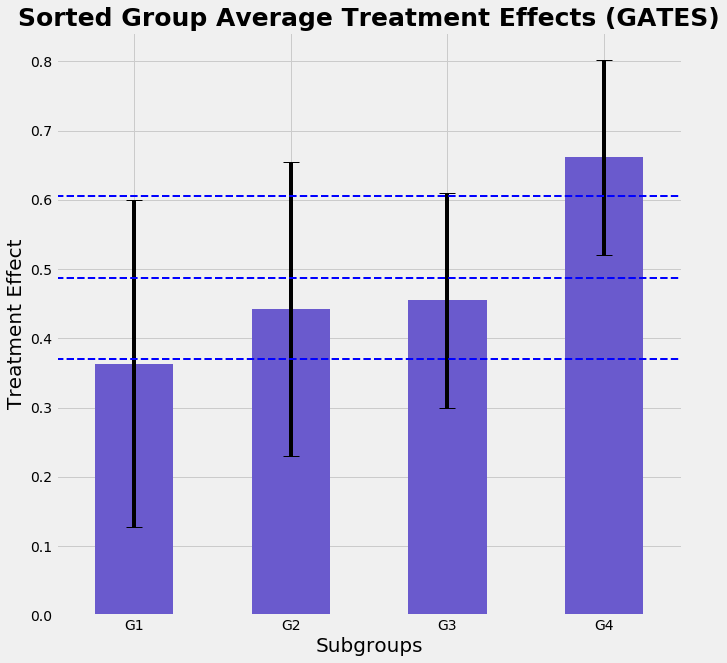

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

coef_df2.plot.bar(x='varname', y='coef', 
             ax=ax,  yerr='err', ecolor = "black",
             legend=False, capsize = 8,rot = 0, color = "slateblue")

ax.set_ylabel('Treatment Effect', fontsize = 20)
ax.set_xlabel('Subgroups', fontsize = 20)

ax.axhline(y=0.487, linestyle='--', color='blue', linewidth=2)
ax.axhline(y=0.370, linestyle='--', color='blue', linewidth=2)
ax.axhline(y=0.605, linestyle='--', color='blue', linewidth=2)# can modify this to include ATE 
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['G1', 'G2', 'G3', 'G4', 'G5'], 
                       rotation=0, fontsize=14)

plt.title("Sorted Group Average Treatment Effects (GATES)", fontsize=25,
            fontweight='bold',
            color='Black')

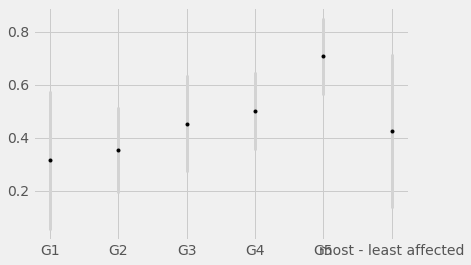

In [42]:
coef = res[5].iloc[0]
err = np.array(res[5].iloc[0] - res[5].iloc[3])
varname = res[5].columns

plt.errorbar(x = varname, y = coef, yerr= err, fmt='.k', ecolor='lightgray', elinewidth=3, capsize=0);

### Girls vs Boys 

Let me repeat this for girls vs boys to see if we can get similar results as the paper.

In [ ]:
df2_girls = df2[df2["f07_girl_cnt"] ==1]
df2_boys = df2[df2["f07_girl_cnt"] ==0]

In [ ]:
controls2 = ["f07_heads_child_cnt", "f07_age_cnt", 
            "f07_duration_village_cnt", "f07_age_head_cnt", "f07_yrs_ed_head_cnt", 
           "f07_jeribs_cnt", "f07_num_sheep_cnt", 
           "f07_farsi_cnt", "f07_tajik_cnt", "f07_farmer_cnt", "f07_num_ppl_hh_cnt", 
           "f07_nearest_scl"] # dropped control for gender

Generic_ML_single(df2_girls, treatment, outcome, controls2, 50, "SVM", 0.05, 5, fixed_effects)

For girls, there is further heterogeneity for age of household's head, but there is not much theoretical reasoning for that. ATE for girls is 0.543. I am unsure if it is right to split the data into 2 because that may cause a reduction in power(?). 

We are unable to see any heterogeneity along age and distance to school, which was obtained from the original analysis and was consistent with the explanation in the original paper. 

In [ ]:
Generic_ML_single(df2_boys, treatment, outcome, controls2, 50, "SVM", 0.05, 5)

We observe not much heterogeneity amongst boys.

## Outcome: Fall 2007 test scores


In [ ]:
outcome2 = "f07_both_norma_total" # test scores

controls = ["f07_heads_child_cnt", "f07_girl_cnt", "f07_age_cnt", 
            "f07_duration_village_cnt", "f07_age_head_cnt", "f07_yrs_ed_head_cnt", 
           "f07_jeribs_cnt", "f07_num_sheep_cnt", 
           "f07_farsi_cnt", "f07_tajik_cnt", "f07_farmer_cnt", "f07_num_ppl_hh_cnt", 
           "f07_nearest_scl"]  

cols_to_add = []
cols_to_add.append(treatment)
cols_to_add.append(outcome2)
cols_to_add.extend(controls)
cols_to_add.append(fixed_effects)

df3 = df[cols_to_add]
df3 = df3.join(states)
# df.join(ps.propscore)
df3.loc[:,"propscore"] = 5/11
df3.dropna(inplace = True)
df3.shape

In [ ]:
df3.columns

In [ ]:
res2 = Generic_ML_single(df3, treatment, outcome2, controls, 60, "random_forest", 0.05, 5, fixed_effects)

In [ ]:
res2[0].round(3)

In [ ]:
res2[1].round(3)

In [ ]:
res2[2].round(3)

Here, we have heterogeneity along girls and age. 

In [ ]:
res3 = Generic_ML_single(df3, treatment, outcome2, controls, 100, "SVM", 0.05, 5, fixed_effects)

In [ ]:
res3[0].round(3) #SVM fails to give us heterogeneity. In fact, HET is negative which is weird

# Outcome: Spring 2008 Enrollment

In [ ]:
outcome3 = "s08_formal_school" # enrollment in Spring 2008

controls_07 = ["f07_heads_child_cnt", "f07_girl_cnt", "f07_age_cnt", 
            "f07_duration_village_cnt", "f07_age_head_cnt", "f07_yrs_ed_head_cnt", 
           "f07_jeribs_cnt", "f07_num_sheep_cnt", 
           "f07_farsi_cnt", "f07_tajik_cnt", "f07_farmer_cnt", "f07_num_ppl_hh_cnt", 
           "f07_nearest_scl"]  

controls_08 = ["f07_heads_child_cnt", "f07_girl_cnt", "s08_age_cnt", 
            "s08_duration_village_cnt", "s08_age_head_cnt", "s08_yrs_ed_head_cnt", 
           "s08_jeribs_cnt", "s08_num_sheep_cnt", 
           "s08_farsi_cnt", "s08_tajik_cnt", "s08_farmer_cnt", "s08_num_ppl_hh_cnt", 
           "s08_nearest_scl"] 

# Can try combining both - not sure if useful or increasing variance

cols_to_add = []
cols_to_add.append(treatment)
cols_to_add.append(outcome3)
cols_to_add.extend(controls_08)
cols_to_add.append(fixed_effects)

df4 = df[cols_to_add]
df4 = df4.join(states)
# df.join(ps.propscore)
df4.loc[:,"propscore"] = 5/11
df4.dropna(inplace = True)
df4.shape

In [ ]:
Generic_ML_single(df4, treatment, outcome3, controls_08, 60, "random_forest", 0.05, 5, fixed_effects)

# Outcome: Spring 2008 Test Scores

In [ ]:
outcome4 = "s08_both_norma_total" # enrollment in Spring 2008

controls_07 = ["f07_heads_child_cnt", "f07_girl_cnt", "f07_age_cnt", 
            "f07_duration_village_cnt", "f07_age_head_cnt", "f07_yrs_ed_head_cnt", 
           "f07_jeribs_cnt", "f07_num_sheep_cnt", 
           "f07_farsi_cnt", "f07_tajik_cnt", "f07_farmer_cnt", "f07_num_ppl_hh_cnt", 
           "f07_nearest_scl"]  

controls_08 = ["f07_heads_child_cnt", "f07_girl_cnt", "s08_age_cnt", 
            "s08_duration_village_cnt", "s08_age_head_cnt", "s08_yrs_ed_head_cnt", 
           "s08_jeribs_cnt", "s08_num_sheep_cnt", 
           "s08_farsi_cnt", "s08_tajik_cnt", "s08_farmer_cnt", "s08_num_ppl_hh_cnt", 
           "s08_nearest_scl"] 

# Can try combining both - not sure if useful or increasing variance

cols_to_add = []
cols_to_add.append(treatment)
cols_to_add.append(outcome4)
cols_to_add.extend(controls_08)
cols_to_add.append(fixed_effects)

df5 = df[cols_to_add]
df5 = df5.join(states)
# df.join(ps.propscore)
df5.loc[:,"propscore"] = 5/11
df5.dropna(inplace = True)
df5.shape

In [ ]:
Generic_ML_single(df5, treatment, outcome4, controls_08, 60, "random_forest", 0.05, 5, fixed_effects)

# Draft: Editing functions for fixed effects

For fixed effects, it is the same as running a regression but with additional controls. I have to drop the first dummy variable but otherwise everywhere that I run a normal regression with controls, I should include the fixed effects. 

These areas are: 
1. ML estimator - need to include fixed effects
2. CLAN - not sure if I have to?

Additionally, I want to include clustered standard errors. 

In [ ]:
fixed_effects = None
fixed_effects

In [ ]:
def ML_estimator(main, aux, model, treatment, outcome, controls, fixed_effects = None):
    if fixed_effects == None, 
        ML_estimator_nofe(main, aux, model, treatment, outcome, controls)

In [ ]:
## ML estimator
# Initialization
main, aux = sklearn.model_selection.train_test_split(df3, train_size = 5/11)

In [ ]:
cols = [treatment] + controls + list(states.columns)
aux0 = aux[aux[treatment] == 0]
aux1 = aux[aux[treatment] == 1]
X_aux0 = aux0.loc[:,cols]
y_aux0 =aux0[outcome]
X_aux1 = aux1.loc[:,cols]
y_aux1 =aux1[outcome]
    
X_main = main.loc[:,cols]
y_main = main[outcome]

In [ ]:
main2 = random_forest(main, X_aux0, y_aux0, X_main, X_aux1, y_aux1)

In [ ]:
CLAN(main2, treatment, controls, alpha)